# 信贷申请评分卡_A卡案例

主要项目流程：数据获取、数据清洗(特征初筛)、特征工程、模型建立、模型评价、模型优化等


In [1]:
import pandas as pd
import numpy as np

# 1.数据获取

In [2]:
# 数据基本描述：信贷申请数据--42535个样本，144个特征

In [3]:
data = pd.read_excel('LoanStats_2018Q3.xlsx')
data.shape

(42535, 144)

In [4]:
# 特征列表
feature_list = list(data)
print(feature_list)

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths

In [5]:
df = data.copy()

In [6]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,2,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,Ryder,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
2,3,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
3,4,10000,10000,10000.0,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
4,5,3000,3000,3000.0,60 months,0.1269,67.79,B,B5,University Medical Group,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


# 2.数据清洗（特征初筛）

In [7]:
# 2.1 申请评分卡使用的数据不能是借款人借款后的信息，需删除18个特征
del_feature_list = ['sub_grade','grade','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
                    'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                    'last_pymnt_amnt','last_credit_pull_d','collections_12_mths_ex_med','policy_code','disbursement_method']
print(df.shape)
df_01 = df.copy().drop(columns=del_feature_list, axis=1)
df_01.shape

(42535, 144)


(42535, 126)

In [8]:
# 2.2 删除客户隐私的字段:['emp_title','title']
customer_info = ['emp_title','title']
df_02 = df_01.drop(columns=customer_info, axis=1)
df_02.shape

(42535, 124)

In [9]:
# 2.3 去重，删除空行
df_03 = df_02.drop_duplicates('id').dropna(axis=0, how='all')
df_03.shape

(42535, 124)

In [48]:
# 2.4 删除缺失率大于0.95的字段
# is_null = [df_03[i_feature].isnull().sum() for i_feature in list(df_03)]
cols_null = []
for col_null in df_03.columns:
    if df_03[col_null].isnull().sum() > (df_03.shape[0])*0.95:
        cols_null.append(col_null)
print(len(cols_null))
df_04 = df_03.drop(cols_null, axis=1)
df_04.shape

86


(42535, 38)

In [49]:
# 例：唯一值
# 2.5 判断每个特征值的分布，若存在某一个值占比超过95%，则删除(分箱前提)
col_handle = []
for col_ in df_04.columns:
    if df_04[col_].value_counts().max() > df_04.shape[0]*0.95:
        col_handle.append(col_)
print(col_handle)
df_05 = df_04.drop(col_handle, axis=1)
df_05.shape

['pymnt_plan', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'hardship_flag', 'debt_settlement_flag']


(42535, 30)

In [50]:
# 2.6 删除id号
df_06 = df_05.drop('id', axis=1)
df_06.shape

(42535, 29)

In [52]:
# 2.7 查看借款期限，并选出借款36期的样本
print(df_06['term'].value_counts())
df_06['term'] = df_06['term'].replace(' 36 months', 36).replace(' 60 months', 60)
df_final = df_06[df_06['term']==36]
df_final.shape

 36 months    31534
 60 months    11001
Name: term, dtype: int64


(31534, 29)

In [54]:
# def feature_info(df_final):
#     result_info = []
#     for col_i in df_final.columns:
#         result_info.append(df_final[col_i].unique())
#     return result_info

# result_info = feature_info(df_final)
# result_info

In [164]:
# 2.8 数据类型查看与转换
def obj_feature(df_final):
    obj_feature = []
    for obj_f in df_final.columns:
        if df_final[obj_f].dtypes == 'object':
            obj_feature.append(obj_f)
    print(obj_feature)
    return obj_feature

obj_feature = obj_feature(df_final)

# 连续型特征
other_feature = df_final.columns.drop(obj_feature)
len(other_feature)
print(other_feature)

['emp_length', 'home_ownership', 'verification_status', 'loan_status', 'desc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'total_acc']
Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'annual_inc', 'issue_d', 'dti', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'next_pymnt_d',
       'pub_rec_bankruptcies'],
      dtype='object')


In [137]:
df_final[obj_feature].head()

,emp_length,home_ownership,verification_status,loan_status,desc,purpose,zip_code,addr_state,delinq_2yrs,total_acc
0,10+ years,RENT,Verified,Fully Paid,Borrower added on 12/22/11 > I need to upgra...,credit_card,860xx,AZ,0,9
2,10+ years,RENT,Not Verified,Fully Paid,NaN,small_business,606xx,IL,0,10
3,10+ years,RENT,Source Verified,Fully Paid,Borrower added on 12/21/11 > to pay for prop...,other,917xx,CA,0,37
5,3 years,RENT,Source Verified,Fully Paid,NaN,wedding,852xx,AZ,0,12
7,9 years,RENT,Source Verified,Fully Paid,Borrower added on 12/16/11 > Downpayment for...,car,900xx,CA,0,4


In [138]:
# 特征值查看
# 1) emp_length--工作年限
df_finals = df_final.copy()
# print(df_finals['emp_length'].value_counts())
print(df_finals['emp_length'].unique())

def emp_length_new(x):
    if x=='< 1 year':
        return 0
    elif x=='1 year':
        return 1
    elif x=='10+ years':
        return 11
    elif str(x)=='nan':
        return np.nan
    else:
        return x.replace(' years', '')
    
df_finals['emp_length'] =df_finals['emp_length'].map(lambda x: emp_length_new(x))
df_finals['emp_length'].unique()
df_finals['emp_length'] = df_finals['emp_length'].apply(pd.to_numeric, errors='coerce')
# print('===================================')

# 2) home_ownership--房产权:类别型特征
# print(df_finals['home_ownership'].value_counts())
# print('===================================')

# 3) verification_status--验证状态:类别型特征
# print(df_finals['verification_status'].value_counts())
# print('===================================')

# 4) loan_status--贷款状态:y
# df_finals['loan_status'].value_counts()
df_finals['loan_status'] = df_finals['loan_status'].copy().map(lambda x: 1 if 'Charged Off' in x else 0)
# print(df_finals['loan_status'].value_counts())
# print('===================================')

# 5) desc--自然语言模块，暂不考虑
df_finals = df_finals.drop('desc', axis=1)
# print('===================================')

# 6) purpose--用途：类别型特征
# print(df_finals['purpose'].value_counts())
# print('===================================')

# 7) zip_code--邮政编码
df_finals = df_finals.drop('zip_code', axis=1)
# print('===================================')

# 8) addr_state--地址状态：类别型特征
# print(df_finals['addr_state'].value_counts())
# print('===================================')

# 9) delinq_2yrs：过去两年逾期次数
# print(df_finals['delinq_2yrs'].value_counts())
set(df_finals['delinq_2yrs'])
df_finals['delinq_2yrs'] = df_finals['delinq_2yrs'].apply(pd.to_numeric, errors='coerce')

# 10) total_acc
set(df_finals['total_acc'])
df_finals['total_acc'] = df_finals['total_acc'].apply(pd.to_numeric, errors='coerce')

['10+ years' '3 years' '9 years' '< 1 year' '4 years' '1 year' '6 years'
 '5 years' '2 years' '7 years' '8 years' nan]


In [175]:
# 类别型特征:home_ownership, verification_status, purpose, addr_state
char_feature = ['home_ownership', 'verification_status', 'purpose', 'addr_state']
# 日期型特征：issue_d，earliest_cr_line，next_pymnt_d
time_feature = ['issue_d', 'earliest_cr_line', 'next_pymnt_d']
df_finals[time_feature] = df_finals[time_feature].apply(pd.to_datetime)
# 连续型特征
num_feature = other_feature.drop(time_feature)
for i_f in num_feature:
    df_finals[i_f] = df_finals[i_f].apply(pd.to_numeric, errors='coerce')
df_finals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31534 entries, 0 to 42534
Data columns (total 27 columns):
loan_amnt                 31534 non-null int64
funded_amnt               31534 non-null int64
funded_amnt_inv           31534 non-null float64
term                      31534 non-null int64
int_rate                  31534 non-null float64
installment               31534 non-null float64
emp_length                30699 non-null float64
home_ownership            31534 non-null object
annual_inc                31530 non-null float64
verification_status       31534 non-null object
issue_d                   31534 non-null datetime64[ns]
loan_status               31534 non-null int64
purpose                   31534 non-null object
addr_state                31534 non-null object
dti                       31534 non-null float64
delinq_2yrs               31504 non-null float64
earliest_cr_line          31505 non-null datetime64[ns]
inq_last_6mths            31505 non-null float64
mths_si

In [182]:
# 2.9 特征衍生：loan_amnt贷款额度，annual_inc年收入（贷款收入比）
# df_finals[['loan_amnt','annual_inc', 'issue_d', 'earliest_cr_line', 'next_pymnt_d']]
df_finals['pnt_loan_annual'] = df_finals.loan_amnt/df_finals.annual_inc

# 3.数据分布

In [188]:
import matplotlib.pyplot as plt
#图示离散变量的分布，无返回值；
#df：DataFrame，数据集；cols：list，离散变量名；col_target：str，目标变量，y；
def plot_discrete(data,cols,col_target):
    cnt=len(cols)
    fig1152,ax1152=plt.subplots(cnt,2,figsize=(2*6,cnt*4))
    #变量取值分布
    for i in range(len(cols)):
        df1152=data[cols[i]].value_counts(dropna=False)
        df1152_pnt=100*df1152/df1152.sum()
        df1152.plot(kind='barh',ax=ax1152[i,0])
        ax1152set=ax1152[i,0].set(title=cols[i])
        #图注释，例如：975—3.09%，表示某变量取值下样本数975，占所有样本总数和的比例3.09
        for j in range(len(df1152)):
            ax1152text=ax1152[i,0].text(df1152.iloc[j],j,'%s—%s%%'%(
                df1152.iloc[j],round(df1152_pnt.iloc[j],2)))
    #双变量分布：目标变量按单个变量分组后，组内不同类别样本占比
        df1503=pd.crosstab(data[cols[i]],data[col_target],normalize='index',dropna=False)
        df1503.plot(kind='barh',ax=ax1152[i,1],stacked=True)
        ax1503set=ax1152[i,1].set(title='%s vs loan_status'%cols[i])
        #图注释，例如：80%，20%，表示变量某取值下，样本分为两个不同类别(1和0)，分别占比80,20%，
        for k in range(len(df1503)):
            ax1503set=ax1152[i,1].text(df1503.iloc[k,0],k,
                                       '%s%%'%round(100*df1503.iloc[k,0],2),ha='right')
            ax1503set=ax1152[i,1].text(1,k,'%s%%'%round(100*df1503.iloc[k,1],2),ha='center')
    #自动调整子图布局
    plt.tight_layout()

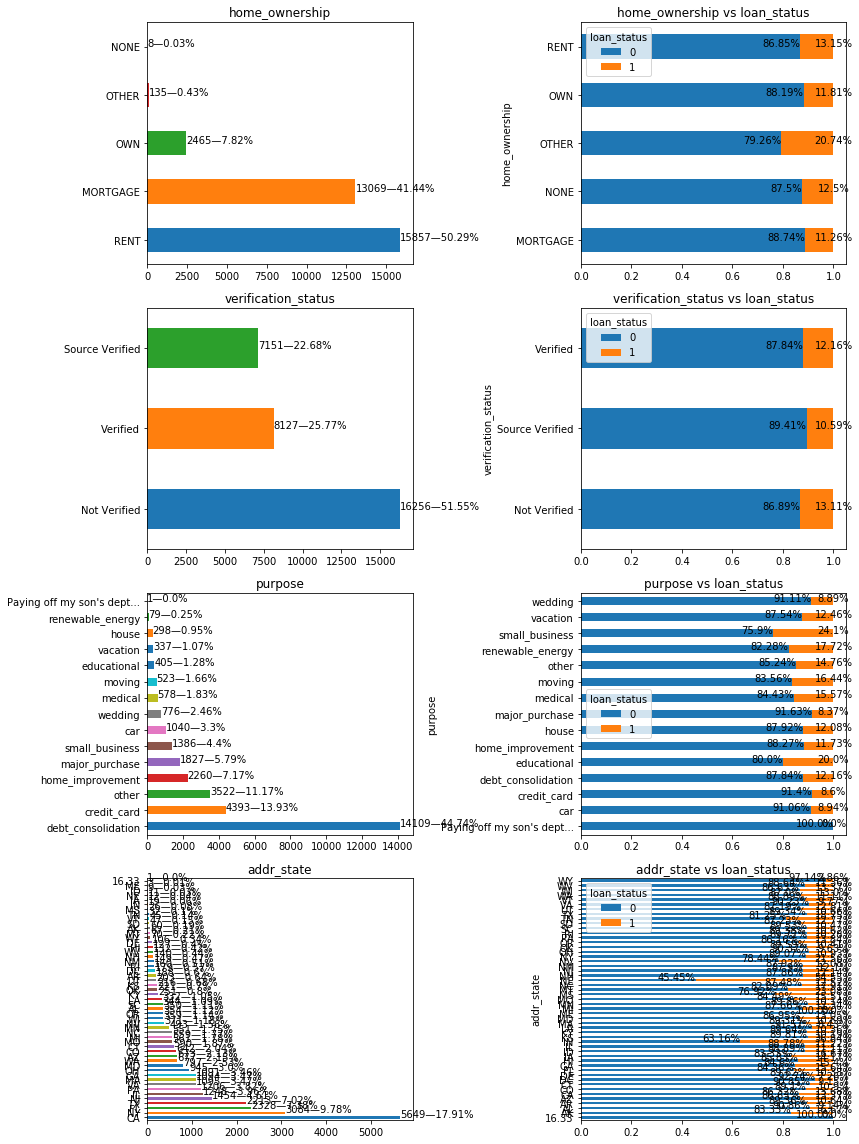

In [189]:
plot_discrete(df_finals,char_feature,'loan_status')